In [72]:
import sys
import os

src_dir = os.path.dirname(os.getcwd())

if src_dir not in sys.path:
    sys.path.append(src_dir)
    
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
from utils import (
    ddpm_schedules, CNN, DDPM, load_pickle, CNNClassifier, save_pickle, calc_loss_per_epoch, load_model
)
from plotting_utils import format_axes
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from accelerate import Accelerator
import torch.nn.functional as F
from tqdm import tqdm
from scipy.linalg import sqrtm

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

ImportError: cannot import name 'load_ddpm' from 'utils' (/Users/adnansiddiquei/Desktop/Cambridge/M2/as3438/src/utils/__init__.py)

# q1a_noise_schedule.png

Text(0, 0.5, '$\\beta_{t}$')

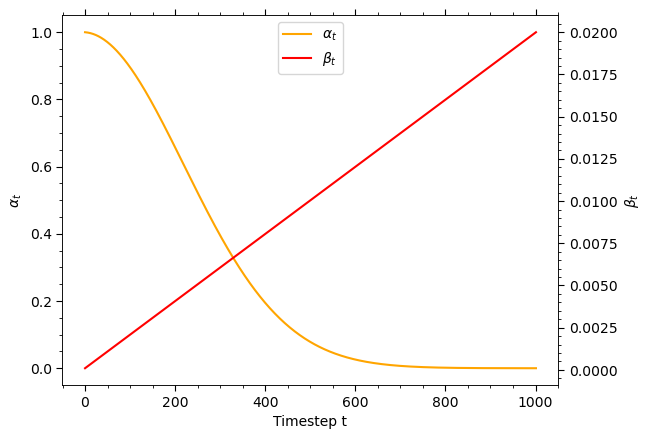

In [4]:
n_T = 1000

noise_schedule = ddpm_schedules(1e-4, 0.02, n_T)
alpha_t = noise_schedule['alpha_t']
beta_t = noise_schedule['beta_t']

x = np.linspace(0, 1001, 1001)

fig, ax = plt.subplots()
plt.plot(x, alpha_t, label=r'$\alpha_{t}$', c='orange')

ax2 = ax.twinx()
plt.plot(x, beta_t, label=r'$\beta_{t}$', c='red')

format_axes([ax, ax2], combine_legends=True, legend_loc='upper center')

ax.set_xlabel('Timestep t')
ax.set_ylabel(r'$\alpha_{t}$')
ax2.set_ylabel(r'$\beta_{t}$')

# plt.savefig(os.path.join(src_dir, f'../report/figures/q1a_noise_schedule.png'), bbox_inches='tight')

# q1a_image_noising.png

In [5]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
dataset = MNIST("../data", train=True, download=False, transform=tf)

In [6]:
torch.manual_seed(42)

mnist_noisy_images = torch.zeros(11 * 4, 1, 28, 28)

for sample in [0, 1, 2, 3]:
    x, label = dataset[sample]
    mnist_noisy_images[sample * 11] = x
    
    for idx, t in enumerate(range(100, 1001, 100)):
        eps = torch.randn_like(x)
        _alpha_t = alpha_t[t]
    
        z_t = torch.sqrt(_alpha_t) * x + torch.sqrt(1 - _alpha_t) * eps
        mnist_noisy_images[(idx + 1) + (sample * 11)] = z_t
    
grid = make_grid(mnist_noisy_images, nrow=11)
# save_image(grid, os.path.join(src_dir, f'../report/figures/q1a_image_noising.png'))

# q1a_image_reconstruction.png

In [7]:
# TODO retrain the original model without the extra hidden layer for the plot below

torch.manual_seed(45)
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(16, 32, 32, 16), act=nn.GELU)
ddpm = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
state_dict = torch.load(f"{src_dir}/models/ddpm_mnist.pth")
ddpm.load_state_dict(state_dict)
ddpm = ddpm.to('mps')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/adnansiddiquei/Desktop/Cambridge/M2/as3438/src/models/ddpm_mnist.pth'

In [ ]:
samples_with_checkpoints = ddpm.sample(4, (1, 28, 28), device='mps', checkpoints=range(900, 0, -100))
samples_with_checkpoints = samples_with_checkpoints.to('cpu')

In [ ]:
save_image(
    make_grid(samples_with_checkpoints.view([44, 1, 28, 28]), nrow=11),
    f'{src_dir}/../report/figures/q1a_image_reconstruction.png'
)

# q1b_noise_schedule.png

In [8]:
model1 = ddpm_schedules(1e-4, 0.02, 1000)
model2 = ddpm_schedules(1e-4, 0.1, 200)
model3 = ddpm_schedules(1e-4, 0.004, 5000)

Text(3500, 0.9025, '$\\beta_{t} = [10^{-4}, 0.004]$ (5000 steps)')

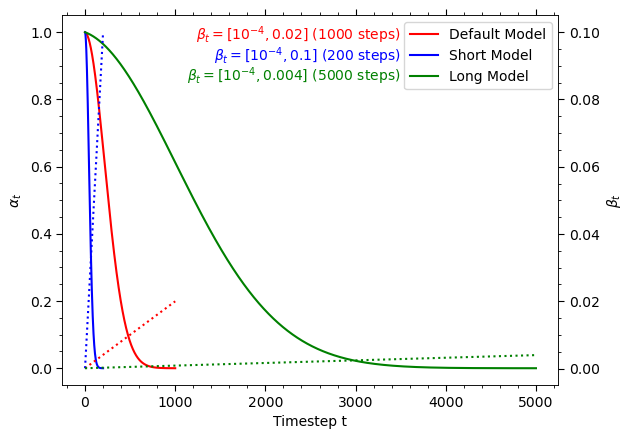

In [9]:
fig, ax = plt.subplots()
plt.plot(model1['alpha_t'], label=r'Default Model', c='red')
plt.plot(model2['alpha_t'], label=r'Short Model', c='blue')
plt.plot(model3['alpha_t'], label=r'Long Model', c='green')

ax2 = ax.twinx()
plt.plot(model1['beta_t'], label=r'$\beta_{t}$', c='red', linestyle=':')
plt.plot(model2['beta_t'], label=r'$\beta_{t}$', c='blue', linestyle=':')
plt.plot(model3['beta_t'], label=r'$\beta_{t}$', c='green', linestyle=':')

ax.legend()
format_axes([ax, ax2], legend_loc='upper center')

ax.set_xlabel('Timestep t')
ax.set_ylabel(r'$\alpha_{t}$')
ax2.set_ylabel(r'$\beta_{t}$')

ax.text(3500, 1.025, r'$\beta_{t} = [10^{-4}, 0.02]$ (1000 steps)', ha='right', va='top', 
         fontsize=10, color='red')
ax.text(3500, 0.9625, r'$\beta_{t} = [10^{-4}, 0.1]$ (200 steps)', ha='right', va='top', 
         fontsize=10, color='blue')
ax.text(3500, 0.9025, r'$\beta_{t} = [10^{-4}, 0.004]$ (5000 steps)', ha='right', va='top', 
         fontsize=10, color='green')

# plt.savefig(f'{src_dir}/../report/figures/q1b_noise_schedules.png', bbox_inches='tight')

# q1b_training_loss.png

In [10]:
losses_1 = load_pickle('../outputs/ddpm/default_model/losses_batch.pkl')
losses_2 = load_pickle('../outputs/ddpm/short_model/losses_batch.pkl')
losses_3 = load_pickle('../outputs/ddpm/long_model/losses_batch.pkl')

In [11]:
loss_epoch_1 = calc_loss_per_epoch(losses_1)
loss_epoch_2 = calc_loss_per_epoch(losses_2)
loss_epoch_3 = calc_loss_per_epoch(losses_3)

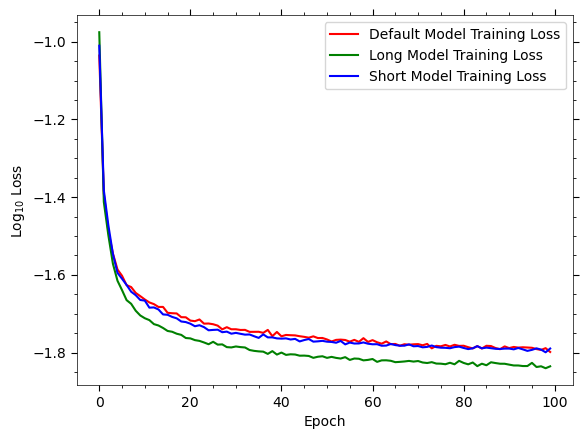

In [12]:
fig, ax = plt.subplots()

plt.plot(np.log10(loss_epoch_1), label='Default Model Training Loss', color='red')
plt.plot(np.log10(loss_epoch_3), label='Long Model Training Loss', color='green')
plt.plot(np.log10(loss_epoch_2), label='Short Model Training Loss', color='blue')
plt.legend()
plt.ylabel(r'Log$_{10}$ Loss')
plt.xlabel(r'Epoch')
format_axes(ax)

# plt.savefig(f'{src_dir}/../report/figures/q1b_training_loss.png', bbox_inches='tight')

# q1b_short_model_nd.png + q1b_long_model_nd.png

In [13]:
tf = transforms.Compose([transforms.ToTensor()])
dataset = MNIST("../data", train=True, download=False, transform=tf)

In [4]:
def_model = load_model('ddpm/default_model', 99)
short_model = load_model('ddpm/short_model', 99)
long_model = load_model('ddpm/long_model', 99)

In [35]:
def generate_image_encoding(model: DDPM, num_samples: int, dataset: MNIST, sample_ranges: range):
    model = model.to('cpu')
    torch.manual_seed(42)
    mnist_noisy_images = torch.zeros(11 * num_samples, 1, 28, 28)
    
    alpha_t = model.alpha_t
    beta_t = model.beta_t
    
    for sample in range(num_samples):
        x, label = dataset[sample]
        mnist_noisy_images[sample * 11] = x
        
        for idx, t in enumerate(sample_ranges):
            eps = torch.randn_like(x)
            _alpha_t = alpha_t[t]
        
            z_t = torch.sqrt(_alpha_t) * x + torch.sqrt(1 - _alpha_t) * eps
            mnist_noisy_images[(idx + 1) + (sample * 11)] = z_t
    
    return mnist_noisy_images.to('cpu')

def generate_image_decoding(model: DDPM, num_samples: int, sample_range: range):
    with torch.no_grad():
        model = model.to(device)
        samples_with_checkpoints = model.sample(num_samples, (1, 28, 28), device=device, checkpoints=sample_range)
        model = model.to('cpu')
        
    return samples_with_checkpoints.to('cpu')

In [39]:
def_model_encoding = generate_image_encoding(def_model, 1, dataset, range(100, 1001, 100))
def_model_decoding = generate_image_decoding(def_model, 2, range(900, 0, -100))

encoding_and_decoding = torch.cat([def_model_encoding, def_model_decoding.view([22, 1, 28, 28])], dim=0)
save_image(make_grid(encoding_and_decoding, nrow=11), f'{src_dir}/../report/figures/q1b_def_model_nd.png')

In [40]:
def_model_encoding = generate_image_encoding(short_model, 1, dataset, range(20, 201, 20))
def_model_decoding = generate_image_decoding(short_model, 2, range(180, 0, -20))

encoding_and_decoding = torch.cat([def_model_encoding, def_model_decoding.view([22, 1, 28, 28])], dim=0)
save_image(make_grid(encoding_and_decoding, nrow=11), f'{src_dir}/../report/figures/q1b_short_model_nd.png')

In [42]:
def_model_encoding = generate_image_encoding(long_model, 1, dataset, range(500, 5001, 500))
def_model_decoding = generate_image_decoding(long_model, 2, range(4500, -0, -500))

encoding_and_decoding = torch.cat([def_model_encoding, def_model_decoding.view([22, 1, 28, 28])], dim=0)
save_image(make_grid(encoding_and_decoding, nrow=11), f'{src_dir}/../report/figures/q1b_long_model_nd.png')

 # q1b_fmd.png

In [92]:
def get_feature_vector(model, batch):
    with torch.no_grad():
        model.eval()
        feature_vector = model(batch)
        return feature_vector
    
def calculate_fid(real_features, generated_features, eps=1e-6):
    real_features = real_features.numpy()
    generated_features = generated_features.numpy()
    
    # Calculate the mean and covariance of the real data and the generated data
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    
    # Adding a small regularization term to the diagonal of covariance matrices
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate the squared difference in means
    ssdiff = ((mu1 - mu2)**2.0).sum()

    # Compute the square root of the product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Check and correct if complex values occurred due to numerical error
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def generate_samples(
        model_name: str, epoch_range: range | list, num_samples
    ):
    all_samples = torch.zeros(len(epoch_range), num_samples, 1, 28, 28)
    
    with torch.no_grad():
        for idx, epoch in enumerate(tqdm(epoch_range)):
            # generate samples
            ddpm = load_model(model_name, epoch).to(device)
            
            samples = ddpm.sample(num_samples, (1, 28, 28), device)
            samples = samples.to('cpu')
            
            all_samples[idx] = samples
            
            del ddpm
            del samples
            
    return all_samples

In [98]:
mnist_classifier = load_model('mnist_classifier', 20)
mnist_classifier.final = nn.Identity()
mnist_classifier

CNNClassifier(
  (blocks): ModuleList(
    (0): CNNBlock(
      (net): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): LayerNorm((32, 28, 28), eps=1e-05, elementwise_affine=True)
        (2): GELU(approximate='none')
      )
    )
    (1): CNNBlock(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): LayerNorm((64, 28, 28), eps=1e-05, elementwise_affine=True)
        (2): GELU(approximate='none')
      )
    )
    (2): CNNBlock(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): LayerNorm((128, 28, 28), eps=1e-05, elementwise_affine=True)
        (2): GELU(approximate='none')
      )
    )
    (3): CNNBlock(
      (net): Sequential(
        (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): LayerNorm((64, 28, 28), eps=1e-05, elementwise_affine=True)
        (2): GELU(a

In [100]:
tf = transforms.Compose([transforms.ToTensor()])
dataset = MNIST("../data", train=False, download=False, transform=tf)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=4, drop_last=True)
real_mnist = next(iter(dataloader))[0]
real_features = get_feature_vector(mnist_classifier, real_mnist)
real_features.shape

torch.Size([512, 1024])

In [101]:
epoch_range = list(range(0, 30, 5)) + list(range(30, 100, 10)) + [99]
samples_def = generate_samples('ddpm/default_model', epoch_range, 32)
samples_short = generate_samples('ddpm/short_model', epoch_range, 32)
samples_long = generate_samples('ddpm/long_model', epoch_range, 32)

100%|██████████| 14/14 [07:53<00:00, 33.81s/it]


In [102]:
feature_vectors_def = torch.empty(samples_def.shape[0], 32, 1024)
feature_vectors_short = torch.empty(samples_short.shape[0], 32, 1024)
feature_vectors_long = torch.empty(samples_long.shape[0], 32, 1024)

for i in tqdm(range(samples_short.shape[0])):
    feature_vectors_def[i] = get_feature_vector(mnist_classifier, samples_def[i])
    feature_vectors_short[i] = get_feature_vector(mnist_classifier, samples_short[i])
    feature_vectors_long[i] = get_feature_vector(mnist_classifier, samples_long[i])

100%|██████████| 14/14 [00:04<00:00,  3.29it/s]


In [103]:
fids_def = torch.empty(samples_def.shape[0])
fids_short = torch.empty(samples_short.shape[0])
fids_long = torch.empty(samples_long.shape[0])

for i in tqdm(range(samples_short.shape[0])):
    fids_def[i] = calculate_fid(real_features, feature_vectors_def[i])
    fids_short[i] = calculate_fid(real_features, feature_vectors_short[i])
    fids_long[i] = calculate_fid(real_features, feature_vectors_long[i])

100%|██████████| 14/14 [01:09<00:00,  4.99s/it]


In [116]:
# and now we compute to see where the average FMD for the real data lies
another_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=True)
fmds_mnist = torch.empty(15)

for i in tqdm(range(len(fmds_mnist))):
    sample = next(iter(another_dataloader))[0]
    feature_vector = get_feature_vector(mnist_classifier, sample)
    fmds_mnist[i] = calculate_fid(real_features, feature_vector)

100%|██████████| 15/15 [01:02<00:00,  4.14s/it]


In [143]:
# and now compute the FMD for a completely black image
black_image = torch.zeros(2, 1, 28, 28)
black_feature_vector = get_feature_vector(mnist_classifier, black_image)
fmd_black = calculate_fid(real_features, black_feature_vector)
fmd_black

759.2862059891254

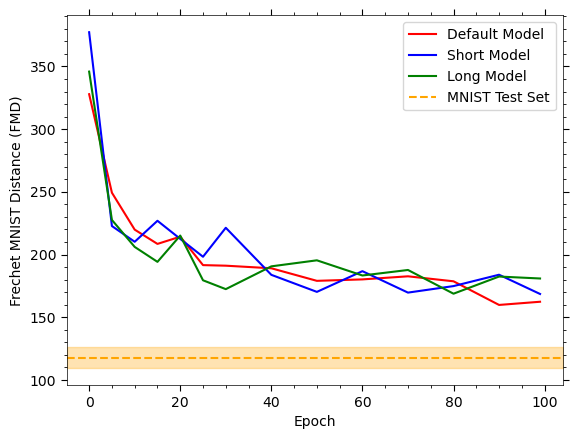

In [183]:
# Un-normalised plot
fig, ax = plt.subplots()
plt.plot(epoch_range, fids_def, label='Default Model', color='red')
plt.plot(epoch_range, fids_short, label='Short Model', color='blue')
plt.plot(epoch_range, fids_long, label='Long Model', color='green')

plt.ylabel(r'Frechet MNIST Distance (FMD)')
plt.xlabel(r'Epoch')

mean, std = fmds_mnist.mean(), fmds_mnist.std()
xlims = plt.xlim()
plt.axhline(y=mean, color='orange', linestyle='--', label='MNIST Test Set')
plt.fill_between(np.linspace(xlims[0], xlims[1]), mean - std, mean + std, color='orange', alpha=0.3)
plt.xlim(xlims)

plt.legend()
format_axes(ax)
plt.xlabel(r'Epoch')
# plt.savefig(f'{src_dir}/../report/figures/q1b_fmd.png', bbox_inches='tight')

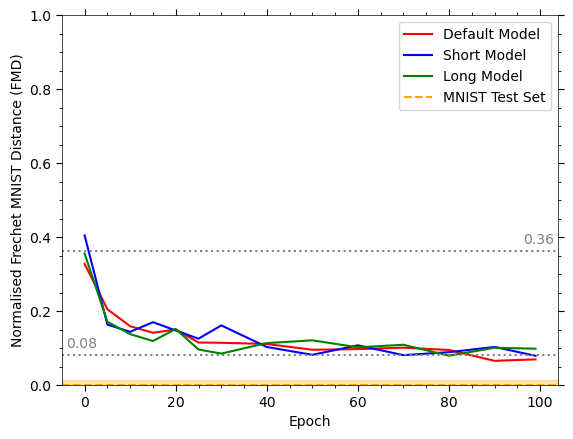

In [206]:
# Normalised plot
def normalise_fmd(fmds):
    return (fmds - mean) / (fmd_black - mean)

fids_def_normalised = normalise_fmd(fids_def)
fids_short_normalised = normalise_fmd(fids_short)
fids_long_normalised = normalise_fmd(fids_long)

# Un-normalised plot
fig, ax = plt.subplots()
plt.plot(epoch_range, fids_def_normalised, label='Default Model', color='red')
plt.plot(epoch_range, fids_short_normalised, label='Short Model', color='blue')
plt.plot(epoch_range, fids_long_normalised, label='Long Model', color='green')

plt.ylabel(r'Normalised Frechet MNIST Distance (FMD)')
plt.xlabel(r'Epoch')

plt.ylim([0, 1])
xlims = plt.xlim()
plt.axhline(y=0, color='orange', linestyle='--', label='MNIST Test Set')
plt.fill_between(np.linspace(xlims[0], xlims[1]), normalise_fmd(mean - std), normalise_fmd(mean + std), color='orange', alpha=0.3)
plt.xlim(xlims)

start_mean = np.mean([fids_def_normalised[0], fids_short_normalised[0], fids_long_normalised[0]])
end_mean = np.mean([fids_def_normalised[-1], fids_short_normalised[-1], fids_long_normalised[-1]])

plt.axhline(y=start_mean, color='grey', linestyle=':')
plt.axhline(y=end_mean, color='grey', linestyle=':')

plt.text(103, start_mean + 0.01, f'{start_mean:.2f}', ha='right', va='bottom', fontsize=10, color='grey')
plt.text(-4, end_mean + 0.01, f'{end_mean:.2f}', ha='left', va='bottom', fontsize=10, color='grey')

# Formatting
plt.legend()
format_axes(ax)
plt.xlabel(r'Epoch')
# plt.savefig(f'{src_dir}/../report/figures/q1b_fmd_normalised.png', bbox_inches='tight')

# q1b_samples.png

In [235]:
epoch_range = list(range(0, 100, 10)) + [99]
samples_def = generate_samples('ddpm/default_model', epoch_range, 2)
samples_short = generate_samples('ddpm/short_model', epoch_range, 2)
samples_long = generate_samples('ddpm/long_model', epoch_range, 2)

100%|██████████| 11/11 [03:18<00:00, 18.08s/it]


In [238]:
temp = torch.empty(len(epoch_range) * 2, 1, 28, 28)

for model, output_file in zip([samples_def, samples_short, samples_long], ['def', 'short', 'long']):
    for i in range(len(epoch_range)):
        temp[i] = model[i, 0]
        temp[i + len(epoch_range)] = model[i, 1]
    
    save_image(make_grid(temp, nrow=len(epoch_range)), f'{src_dir}/../report/figures/q1b_samples_{output_file}.png')

In [237]:
samples_def_final = generate_samples('ddpm/default_model', [99], 36)
samples_short_final = generate_samples('ddpm/short_model', [99], 36)
samples_long_final = generate_samples('ddpm/long_model', [99], 36)

100%|██████████| 1/1 [00:38<00:00, 38.25s/it]


In [239]:
for model, output_file in zip([samples_def_final, samples_short_final, samples_long_final], ['def', 'short', 'long']):
    save_image(make_grid(model.view([36, 1, 28, 28]), nrow=4), f'{src_dir}/../report/figures/q1b_samples_{output_file}_final.png')